In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy
import numpy as np
import time
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import pandas as pd

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Script is running with GPU')
else:
  device = torch.device("cpu")
  print('Script is running WITHOUT GPU')

Script is running with GPU


In [ ]:
sents = list(np.load('OS_sents.npy', allow_pickle=True))
tags = list(np.load('OS_tags_minimal.npy', allow_pickle=True))
problems = []

In [ ]:
usable_sents = []
usable_tags = []
for idx, sent in enumerate(sents):
  tempsent = []
  temptags = []
  for i, word in enumerate(sent):
    if tags[idx][i] != 'PUNCT':
      tempsent.append(word)
      temptags.append(tags[idx][i])
  usable_sents.append(tempsent)
  usable_tags.append(temptags)

In [ ]:
#for idx, sent in enumerate(sents):
#  sent.insert(0, 'start')
#  sent.append('stop')
#  sents[idx] = sent
#for idx, sent in enumerate(tags):
#  sent.insert(0, 'start')
#  sent.append('stop')
#  tags[idx] = sent
#for idx, sent in enumerate(tags):
#  if 'XX' in sent:
#    problems.append(idx)

In [ ]:
rawwords = []
for sent in sents:
  for word in sent:
    rawwords.append(word)

rawtags = []
for sequence in usable_tags:
  for tag in sequence:
    rawtags.append(tag)

In [ ]:
len(sents)

3549

In [ ]:
allwords = list(set(rawwords))
alltags = list(set(rawtags))

In [ ]:
alltags

['Q',
 'D',
 'NUM',
 'ADJ',
 'NEG',
 'ADV',
 'CONJ',
 'N',
 'start',
 'C',
 'WH',
 'PRO',
 'VB',
 'INTJ',
 'PART',
 'P',
 'stop',
 'PRO$',
 'XX']

In [ ]:
charsents = []
for sent in usable_sents:
  charsent = []
  for word in sent:
    if word == 'start':
      charsent.append([word])
    elif word == 'stop':
      charsent.append([word])
    else:
      charsent.append(['$']+list(word.lower())+['%'])
  charsents.append(charsent)

In [ ]:
len(usable_sents)

3549

In [ ]:
len(charsents)

3549

In [ ]:
allchars = []
for sent in charsents:
  for word in sent:
    for char in word:
      allchars.append(char)

In [ ]:
allchars = list(set(allchars))

In [ ]:
allchars

['o',
 'v',
 's',
 'd',
 'm',
 'e',
 'đ',
 '%',
 'g',
 'p',
 'r',
 'l',
 'start',
 't',
 'q',
 'i',
 'c',
 'b',
 'k',
 'f',
 'h',
 'u',
 'a',
 'stop',
 '$',
 'ƀ',
 'n',
 'z',
 'y']

In [ ]:
word_tokenizer = {word: idx+1 for idx, word in enumerate(allwords)}
word_decoder = {idx+1: word for idx, word in enumerate(allwords)}
tag_tokenizer = {tag: idx+1 for idx, tag in enumerate(alltags)}
tag_decoder = {idx+1: tag for idx, tag in enumerate(alltags)}
char_tokenizer = {char: idx+1 for idx, char in enumerate(allchars)}
char_decoder = {idx+1: char for idx, char in enumerate(allchars)}

def tokenize_sent(sentences, tokenizer):
  indexed_sentences = []
  for sentence in sentences:
    indexed_sentence = [tokenizer[word] for word in sentence]
    indexed_sentences.append(indexed_sentence)
  return indexed_sentences

def tokenize_word(sentences, tokenizer):
  indexed_sentences = []
  for sentence in sentences:
    indexed_words = []
    for word in sentence:
      indexed_word = [tokenizer[char] for char in word]
      indexed_words.append(indexed_word)
    indexed_sentences.append(indexed_words)
  return indexed_sentences

encsents = tokenize_sent(usable_sents, word_tokenizer)
enctags = tokenize_sent(usable_tags, tag_tokenizer)
encchars = tokenize_word(charsents, char_tokenizer)

In [ ]:
encchars[0]

[[13],
 [25, 5, 23, 27, 6, 9, 23, 8],
 [25, 22, 22, 23, 11, 1, 27, 8],
 [25, 14, 21, 6, 8],
 [25, 3, 16, 23, 8],
 [25, 16, 11, 1, 8],
 [25, 5, 1, 4, 8],
 [25, 9, 6, 3, 10, 1, 27, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 3, 16, 23, 8],
 [25, 22, 22, 1, 11, 4, 8],
 [25, 9, 1, 4, 6, 3, 8],
 [25, 22, 22, 16, 3, 6, 23, 27, 8],
 [25, 18, 16, 9, 22, 27, 27, 22, 27, 8],
 [25, 11, 6, 17, 19, 6, 23, 27, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 9, 16, 11, 22, 27, 16, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 14, 21, 16, 6, 8],
 [25, 11, 16, 17, 6, 1, 8],
 [25, 17, 11, 16, 3, 14, 8],
 [25, 22, 27, 4, 23, 11, 8],
 [25, 5, 23, 27, 17, 22, 27, 27, 6, 23, 8],
 [25, 5, 23, 11, 16, 14, 21, 23, 8],
 [25, 9, 16, 20, 11, 22, 5, 16, 4, 23, 8],
 [25, 5, 16, 4, 8],
 [25, 22, 22, 1, 11, 4, 22, 27, 8],
 [25, 6, 27, 4, 16, 8],
 [25, 5, 16, 4, 8],
 [25, 22, 22, 6, 11, 17, 22, 27, 8],
 [24]]

In [ ]:
padsents, padtags, padchars1 = [], [], []

maxlen = max(len(sublist) for sublist in encsents)
for sublist in encsents:
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padsents.append(sublist)

allenctags = []
maxlen = max(len(sublist) for sublist in enctags)
for sublist in enctags:
  for i in sublist:
    allenctags.append(i)
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padtags.append(sublist)

maxlen = max(len(sublist) for sublist in encchars)
for sublist in encchars:
  while len(sublist) < maxlen:
    sublist = sublist + [[0]]
    if len(sublist) == maxlen:
      break
    sublist = [[0]] + sublist
  padchars1.append(sublist)

In [ ]:
padchars1[0]

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [13],
 [25, 5, 23, 27, 6, 9, 23, 8],
 [25, 22, 22, 23, 11, 1, 27, 8],
 [25, 14, 21, 6, 8],
 [25, 3, 16, 23, 8],
 [25, 16, 11, 1, 8],
 [25, 5, 1, 4, 8],
 [25, 9, 6, 3, 10, 1, 27, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 3, 16, 23, 8],
 [25, 22, 22, 1, 11, 4, 8],
 [25, 9, 1, 4, 6, 3, 8],
 [25, 22, 22, 16, 3, 6, 23, 27, 8],
 [25, 18, 16, 9, 22, 27, 27, 22, 27, 8],
 [25, 11, 6, 17, 19, 6, 23, 27, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 9, 16, 11, 22, 27, 16, 8],
 [25, 14, 21, 23, 14, 8],
 [25, 14, 21, 16, 6, 8],
 [25, 11, 16, 17, 6, 1, 8],
 [25, 17, 11, 16, 3, 14, 8],
 [25, 22, 27, 4, 23, 11, 8],
 [25, 5, 23, 27, 17, 22, 27, 27, 6, 23, 8],
 [25, 5, 23, 11, 16, 14, 21, 23, 8],
 [25, 9, 16, 20, 11, 22, 5, 16, 4, 23, 8],
 [25, 5, 16, 4, 8],
 [25, 22, 22, 1, 11, 4, 22, 27, 8],
 [25, 6, 27, 4, 16, 8],
 [25, 5, 16, 4, 8],
 [25, 22, 22, 6, 11, 17, 22, 27, 8],
 [24],
 [

In [ ]:
padchars = []
maxlen_char = 0
for sent in padchars1:
  for sublist in sent:
    if len(sublist) > maxlen_char:
      maxlen_char = len(sublist)
for sent in padchars1:
  temp = []
  for sublist in sent:
    while len(sublist) < maxlen_char:
      sublist = sublist + [0]
      if len(sublist) == maxlen_char:
        break
      sublist = [0] + sublist
    temp.append(sublist)
  padchars.append(temp)


In [ ]:
maxlen_char

17

In [ ]:
for i in range(len(padchars)):
  for j in range(len(padchars[i])):
    if len(padchars[i][j]) != maxlen_char:
      print(i, j)

In [ ]:
len(padchars[179][60])

17

In [ ]:
tag_mask = []
for seq in padtags:
  mask = [1]*len(seq)
  for idx, tag in enumerate(seq):
    if tag == tag_tokenizer['XX']:
      mask[idx] = 0
    if tag == tag_tokenizer['start']:
      mask[idx] = 0
    if tag == tag_tokenizer['stop']:
      mask[idx] = 0
  tag_mask.append(mask)

In [ ]:
pad_tags_mask = []
for i in range(len(padtags)):
  pad_tags_mask.append([padtags[i], tag_mask[i]])

pad_sents_chars = []
for i in range(len(padsents)):
  pad_sents_chars.append([padsents[i], padchars[i]])

In [ ]:
X1_test, X1_train, X2_test, X2_train, y_test, y_train = train_test_split(padsents, padchars, pad_tags_mask, test_size=0.8)
X1_train_tensor = torch.tensor(X1_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X1_test_tensor = torch.tensor(X1_test, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
X2_train_tensor = torch.tensor(X2_train, dtype=torch.long).to(device)
X2_test_tensor = torch.tensor(X2_test, dtype=torch.long).to(device)
train_dataset = TensorDataset(X1_train_tensor, X2_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X1_test_tensor, X2_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#torch.save(train_loader, 'OSTrain.pth')
#torch.save(test_loader, 'OSTest.pth')

In [ ]:
#train_loader = torch.load('OSTrain.pth', map_location=device)
#test_loader = torch.load('OSTest.pth', map_location=device)

In [ ]:
print(X1_train_tensor.size())
print(X2_train_tensor.size())
print(y_train_tensor.size())
print(X1_test_tensor.size())
print(X2_test_tensor.size())
print(y_test_tensor.size())

torch.Size([2840, 78])
torch.Size([2840, 78, 17])
torch.Size([2840, 2, 78])
torch.Size([709, 78])
torch.Size([709, 78, 17])
torch.Size([709, 2, 78])


In [ ]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(unique_classes)
    print(class_counts)
    total_samples = len(y)-(3549*2)
    class_weights = []
    class_weights.append(1)

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = math.log(total_samples / (class_count))
        if class_count == 3549:
          class_weight = 1
        class_weights.append(class_weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    return class_weights

In [ ]:
alltags

['Q',
 'D',
 'NUM',
 'ADJ',
 'NEG',
 'ADV',
 'CONJ',
 'N',
 'start',
 'C',
 'WH',
 'PRO',
 'VB',
 'INTJ',
 'PART',
 'P',
 'stop',
 'PRO$',
 'XX']

In [ ]:
unique_classes, class_counts = np.unique(allenctags, return_counts=True)
print(len(unique_classes))
print(class_counts)

19
[  805  3509   225  3167   608  4655  1112 11823  3549  1398   177  4447
  8728     7    53  3809  3549  1551   106]


In [ ]:
list(set(allenctags))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
tag_decoder

{1: 'Q',
 2: 'D',
 3: 'NUM',
 4: 'ADJ',
 5: 'NEG',
 6: 'ADV',
 7: 'CONJ',
 8: 'N',
 9: 'start',
 10: 'C',
 11: 'WH',
 12: 'PRO',
 13: 'VB',
 14: 'INTJ',
 15: 'PART',
 16: 'P',
 17: 'stop',
 18: 'PRO$',
 19: 'XX'}

In [ ]:
class_weights = calculate_class_weights(allenctags)
print("Class weights:", class_weights)
print(len(class_weights))
print(len(alltags)+1)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[  805  3509   225  3167   608  4655  1112 11823  3549  1398   177  4447
  8728     7    53  3809  3549  1551   106]
Class weights: tensor([1.0000, 4.0495, 2.5772, 5.3242, 2.6798, 4.3301, 2.2946, 3.7264, 1.3625,
        1.0000, 3.4975, 5.5642, 2.3403, 1.6660, 8.7944, 6.7700, 2.4952, 1.0000,
        3.3936, 6.0769], device='cuda:0')
20
20


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

  def categorical_accuracy(self, preds, y, mask, tag_pad_idx = 0):
    max_preds = preds.argmax(dim = 1, keepdim = False)
    max_preds = max_preds*mask
    y = y*mask
    max_preds = torch.flatten(max_preds)
    y = torch.flatten(y)
    non_pad_elements = y.nonzero()
    correct = max_preds[non_pad_elements].eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

  def early_stop(self, validation_loss, patience = 3, min_delta = 0):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.patiencecount = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.patiencecount += 1
        print(f"Early stopping counter: {self.patiencecount} out of {patience}")
        if self.patiencecount >= patience:
            return True
    return False

  def fit(self, train_dl, val_dl, epochs, pad_idx = 0):
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.001)

    self.patiencecount = 0
    self.min_validation_loss = float('inf')

    self.trainlosses = []
    self.vallosses = []

    self.train_accs = []
    self.val_accs = []

    counter = 0
    for epoch in range(epochs):
      for batch in train_dl:
        counter += 1
        words = batch[0]
        chars = batch[1]
        output = batch[2]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        optimizer.zero_grad()
        preds = self.forward(words, chars)
        preds = preds.transpose(1,2)
        loss = self.loss_fn(preds, tags)
        #loss = (loss * mask).sum() / mask.sum()
        loss.backward()
        optimizer.step()
      train_loss, train_acc = self.evaluate(train_dl)
      val_loss, val_acc = self.evaluate(val_dl)
      self.trainlosses.append(train_loss)
      self.vallosses.append(val_loss)
      self.train_accs.append(train_acc)
      self.val_accs.append(val_acc)
      if self.early_stop(val_loss):
        break
      train_acc = train_acc*100
      val_acc = val_acc*100
      print(f"Epoch [{epoch + 1}] - TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}, TrainAcc: {train_acc:.2f},% ValAcc: {val_acc:.2f}%")

  def evaluate(self, val_dl, pad_idx = 0):
    losses = []
    accuracies = []
    with torch.no_grad():
      for batch in val_dl:
          words = batch[0]
          chars = batch[1]
          output = batch[2]
          output = output.transpose(0,1)
          tags = output[0]
          mask = output[1]
          preds = self.forward(words, chars)
          preds = preds.transpose(1,2)
          loss = self.loss_fn(preds, tags)
          #loss = (loss * mask).sum() / mask.sum()
          losses.append(loss)
          acc = self.categorical_accuracy(preds, tags, mask, pad_idx)
          accuracies.append(acc)
    return torch.Tensor(losses).mean(), torch.Tensor(accuracies).mean()

In [ ]:
class OSTagger(Model):
    def __init__(self, vocab, char_vocab, embeds, char_emb, hidden, tagset, n_layers, dropout, criterion, maxlen, maxlen_char, batch_size, pad_idx = 0):
        super().__init__()
        self.maxlen = maxlen
        self.maxlen_char = maxlen_char
        self.batch_size = batch_size
        self.char_emb = char_emb
        self.hidden = hidden
        self.n_layers = n_layers

        self.charembedding = nn.Embedding(char_vocab, char_emb, padding_idx = pad_idx, scale_grad_by_freq = True)
        self.charlstm = nn.LSTM(char_emb, hidden, num_layers = n_layers, bidirectional = True,
                            dropout =  0, batch_first=True)
        self.embedding = nn.Embedding(vocab, embeds, padding_idx = pad_idx, scale_grad_by_freq = True)
        self.lstm = nn.LSTM(embeds + hidden*n_layers*2, hidden, num_layers = n_layers, bidirectional = True,
                            dropout = dropout*1.5 if n_layers > 1 else 0)
        self.lin = nn.Linear(hidden * 2, tagset)

        self.dropout = nn.Dropout(dropout)
        self.loss_fn = criterion

    def forward(self, words, chars):
        x = self.charembedding(chars)
        x = x.reshape(-1, self.maxlen_char, self.char_emb)
        x, (hidden, cell) = self.charlstm(x)
        hidden = hidden.transpose(0,1)
        hidden = hidden.reshape(-1, self.maxlen, self.hidden*self.n_layers*2)
        x = self.embedding(words)
        x = torch.cat((x, hidden), dim = 2)
        x, (hidden, cell) = self.lstm(x)
        x = self.lin(self.dropout(x))
        return x


In [ ]:
vocab = len(allwords)+1
char_vocab = len(allchars)+1
word_emb = 50
char_emb = 200
n_hidden = 300
n_tags = len(alltags)+1
n_layers = 2
dropout = .2
pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, weight=class_weights).to(device)

In [ ]:
network_OSTagger = OSTagger(vocab, char_vocab, word_emb, char_emb, n_hidden, n_tags, n_layers, dropout, criterion, maxlen, maxlen_char, batch_size, pad_idx).to(device)

In [ ]:
%time network_OSTagger.fit(train_loader, test_loader, 100)

Epoch [1] - TrainLoss: 1.0476, ValLoss: 1.0233, TrainAcc: 60.26,% ValAcc: 60.96%
Epoch [2] - TrainLoss: 0.5687, ValLoss: 0.5609, TrainAcc: 79.14,% ValAcc: 78.76%
Epoch [3] - TrainLoss: 0.3700, ValLoss: 0.3864, TrainAcc: 85.69,% ValAcc: 84.39%
Epoch [4] - TrainLoss: 0.2613, ValLoss: 0.2974, TrainAcc: 90.61,% ValAcc: 88.91%
Epoch [5] - TrainLoss: 0.2239, ValLoss: 0.2772, TrainAcc: 91.14,% ValAcc: 88.65%
Epoch [6] - TrainLoss: 0.2002, ValLoss: 0.2702, TrainAcc: 91.61,% ValAcc: 88.40%
Epoch [7] - TrainLoss: 0.1609, ValLoss: 0.2559, TrainAcc: 93.60,% ValAcc: 90.06%
Epoch [8] - TrainLoss: 0.1296, ValLoss: 0.2376, TrainAcc: 95.05,% ValAcc: 91.59%
Epoch [9] - TrainLoss: 0.1083, ValLoss: 0.2334, TrainAcc: 96.02,% ValAcc: 91.89%
Early stopping counter: 1 out of 3
Epoch [10] - TrainLoss: 0.0894, ValLoss: 0.2359, TrainAcc: 96.70,% ValAcc: 92.22%
Early stopping counter: 2 out of 3
Epoch [11] - TrainLoss: 0.0976, ValLoss: 0.2774, TrainAcc: 96.52,% ValAcc: 91.66%
Early stopping counter: 3 out of 3
CP

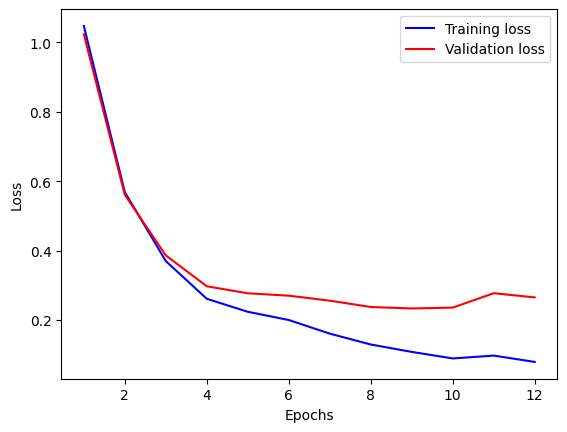

In [ ]:
epochs = range(1, len(network_OSTagger.trainlosses) + 1)

plt.plot(epochs, network_OSTagger.trainlosses, 'blue', label='Training loss')
plt.plot(epochs, network_OSTagger.vallosses, 'red', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

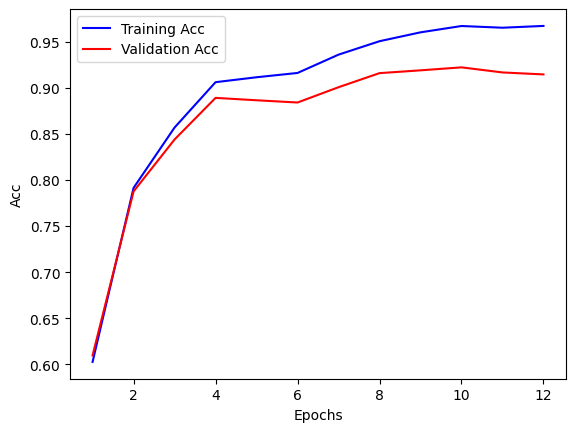

In [ ]:
epochs = range(1, len(network_OSTagger.train_accs) + 1)

plt.plot(epochs, network_OSTagger.train_accs, 'blue', label='Training Acc')
plt.plot(epochs, network_OSTagger.val_accs, 'red', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
def predict(model, data, pad_idx):
    with torch.no_grad():
      predicts_out = []
      tags_out = []
      text_out = []
      for batch in data:
        text = batch[0]
        chars = batch[1]
        output = batch[2]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        predictions = model.forward(text, chars)
        predictions = predictions.transpose(1,2)
        predictions = predictions.argmax(dim = 1)
        for idx, sent in enumerate(text):
          predicts_out.append(np.array(predictions[idx].cpu()))
          tags_out.append(np.array(tags[idx].cpu()))
          text_out.append(np.array(sent.cpu()))
    for idx, ele in enumerate(predicts_out):
      predicts_out[idx] = predicts_out[idx].tolist()
    for idx, ele in enumerate(tags_out):
      tags_out[idx] = tags_out[idx].tolist()
    for idx, ele in enumerate(text_out):
      text_out[idx] = text_out[idx].tolist()

    return predicts_out, tags_out, text_out

In [ ]:
preds, tags, texts = predict(network_OSTagger, test_loader, pad_idx)

In [ ]:
print(preds[0])
print(tags[0])

[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 9, 17, 17, 17, 9, 13, 10, 12, 8, 6, 13, 16, 8, 7, 16, 8, 13, 8, 6, 8, 13, 8, 8, 6, 12, 13, 8, 4, 2, 8, 12, 4, 8, 8, 10, 8, 8, 16, 4, 8, 13, 8, 13, 17, 9, 9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 13, 10, 12, 8, 6, 13, 16, 8, 7, 16, 8, 13, 6, 6, 8, 13, 8, 8, 10, 12, 13, 8, 4, 10, 8, 12, 13, 8, 8, 10, 6, 8, 16, 4, 8, 13, 8, 13, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
for i in range(len(preds)):
  for j in range(len(preds[i])):
    if tags[i][j] == 0:
      preds[i][j] = 0
  preds[i] = [ele for ele in preds[i] if ele != 0]
  tags[i] = [ele for ele in tags[i] if ele != 0]
  texts[i] = [ele for ele in texts[i] if ele != 0]

TypeError: can't assign a list to a torch.cuda.LongTensor

In [ ]:
decpreds, dectags, dectext, declangs = [], [], [], []
decpreds.append(tokenize_sent(preds, tag_decoder))
dectags.append(tokenize_sent(tags, tag_decoder))
dectext.append(tokenize_sent(texts, word_decoder))
decpreds = decpreds[0]
dectags = dectags[0]
dectext = dectext[0]

In [ ]:
print(decpreds[0])
print(dectags[0])
print(dectext[0])

['start', 'VB', 'C', 'PRO', 'N', 'ADV', 'VB', 'P', 'N', 'CONJ', 'P', 'N', 'VB', 'N', 'ADV', 'N', 'VB', 'N', 'N', 'ADV', 'PRO', 'VB', 'N', 'ADJ', 'D', 'N', 'PRO', 'ADJ', 'N', 'N', 'C', 'N', 'N', 'P', 'ADJ', 'N', 'VB', 'N', 'VB', 'stop']
['start', 'VB', 'C', 'PRO', 'N', 'ADV', 'VB', 'P', 'N', 'CONJ', 'P', 'N', 'VB', 'ADV', 'ADV', 'N', 'VB', 'N', 'N', 'C', 'PRO', 'VB', 'N', 'ADJ', 'C', 'N', 'PRO', 'VB', 'N', 'N', 'C', 'ADV', 'N', 'P', 'ADJ', 'N', 'VB', 'N', 'VB', 'stop']
['start', 'quathun', 'that', 'hie', 'giuuerr', 'erist', 'bigunni', 'an', 'Galilealande', 'endi', 'ofar', 'Iuđeon', 'fuor', 'heroduuardes', 'thanan', 'hugi', 'tuiflida', 'manno', 'muodseƀon', 'so', 'hie', 'ist', 'morthes', 'uuerth', 'that', 'man', 'ina', 'uuitno', 'uuapnes', 'eggion', 'ef', 'eo', 'man', 'mid', 'sulicon', 'dadion', 'mag', 'dođes', 'gisculdian', 'stop']


In [ ]:
in_set_vocab = []
for batch in train_loader:
  texts = batch[0]
  for sent in texts:
    sent = sent.tolist()
    sent = [ele for ele in sent if ele != 0]
    x = []
    for i in sent:
      x.append([i])
    x = tokenize_sent(x, word_decoder)
    for word in x:
      in_set_vocab.append(word)
in_set_vocab = set([x for y in in_set_vocab for x in y])

In [ ]:
corrects, incorrects, totals = [], [], []
uk_corrects, uk_incorrects, uk_totals = [], [], []
for i in range(len(decpreds)):
  for j in range(len(decpreds[i])):
    totals.append(dectags[i][j])
    if decpreds[i][j] == dectags[i][j]:
      corrects.append(decpreds[i][j])
    else:
      incorrects.append(decpreds[i][j])
    if dectext[i][j] not in in_set_vocab:
      uk_totals.append(dectags[i][j])
      if decpreds[i][j] == dectags[i][j]:
        uk_corrects.append(decpreds[i][j])
      else:
        uk_incorrects.append(decpreds[i][j])

c_freqs = Counter(corrects)
ic_freqs = Counter(incorrects)
t_freqs = Counter(totals)
uk_c_freqs = Counter(uk_corrects)
uk_ic_freqs = Counter(uk_incorrects)
uk_t_freqs = Counter(uk_totals)

print('Total Accuracy:')
data = []
labels = []
any_c = [x[0] for x in c_freqs.most_common()]
for i in t_freqs.most_common():
  if i[0] not in any_c:
    data.append(0)
    labels.append(i[0])
    print(f'{i[0]} | 0% of {i[1]}')
  else:
    for ele in c_freqs.most_common():
      if ele[0] == i[0]:
        num_c = ele[1]
    class_acc = num_c/i[1]
    data.append(class_acc*100)
    labels.append(i[0])
    print(f'{i[0]} | {class_acc*100:.2f}% of {i[1]}')

Total Accuracy:
N | 95.27% of 2455
VB | 89.52% of 1755
ADV | 85.40% of 952
PRO | 96.83% of 883
P | 99.15% of 822
D | 87.19% of 773
start | 100.00% of 709
stop | 100.00% of 709
ADJ | 81.86% of 623
C | 79.41% of 306
PRO$ | 97.94% of 291
CONJ | 96.09% of 230
Q | 96.00% of 175
NEG | 98.63% of 146
WH | 95.35% of 43
NUM | 93.55% of 31
XX | 83.33% of 24
PART | 80.00% of 5


In [ ]:
plot_list = ['N', 'VB', 'ADV', 'PRO', 'P', 'D', 'ADJ', 'C', 'PRO$', 'CONJ', 'Q', 'NEG', 'NUM', 'WH', 'PART', 'INTJ']

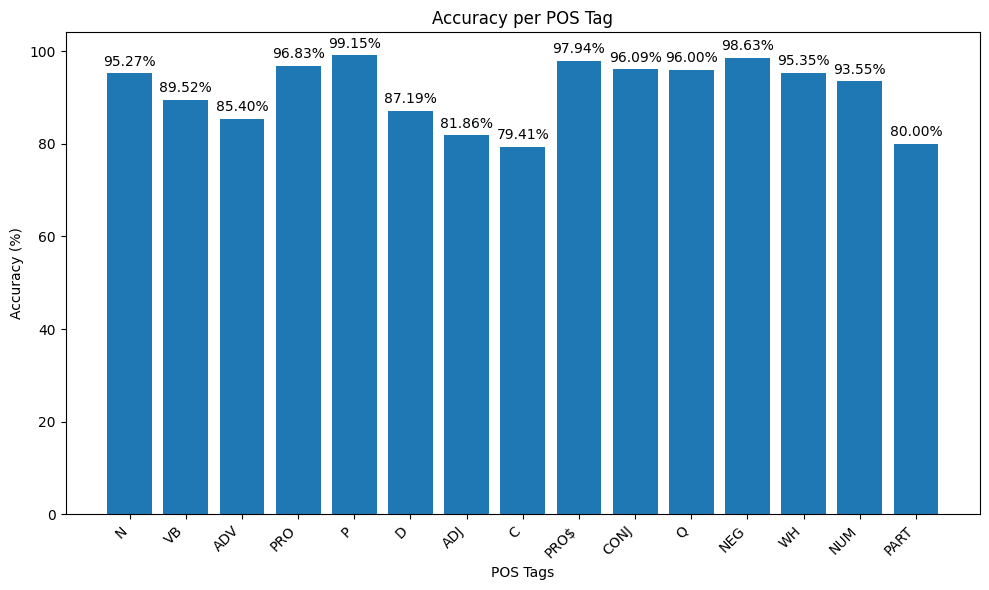

In [ ]:
plot_data = []
plot_labels = []
for label, value in zip(labels, data):
    if label in plot_list:
        plot_data.append(value)
        plot_labels.append(label)

plt.figure(figsize=(10, 6))
plt.bar(plot_labels, plot_data)
plt.xlabel("POS Tags")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per POS Tag")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame({'POS Tag': labels, 'Accuracy (%)': data})
latex_table = df.to_latex(index=False)
latex_table

'\\begin{tabular}{lr}\n\\toprule\nPOS Tag & Accuracy (%) \\\\\n\\midrule\nN & 95.274949 \\\\\nVB & 89.515670 \\\\\nADV & 85.399160 \\\\\nPRO & 96.828992 \\\\\nP & 99.148418 \\\\\nD & 87.192755 \\\\\nstart & 100.000000 \\\\\nstop & 100.000000 \\\\\nADJ & 81.861958 \\\\\nC & 79.411765 \\\\\nPRO$ & 97.938144 \\\\\nCONJ & 96.086957 \\\\\nQ & 96.000000 \\\\\nNEG & 98.630137 \\\\\nWH & 95.348837 \\\\\nNUM & 93.548387 \\\\\nXX & 83.333333 \\\\\nPART & 80.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
v_true = []
v_pred = []
v_word = []

for i, seq in enumerate(dectags):
  for j, tag in enumerate(seq):
    if dectags[i][j] == 'WH':
      v_true.append(dectags[i][j])
      v_pred.append(decpreds[i][j])
      v_word.append(dectext[i][j])


In [ ]:
Counter(v_pred).most_common()

[('WH', 41), ('ADJ', 1), ('ADV', 1)]

In [ ]:
incorrect_c = []
for i, ele in enumerate(c_true):
  if c_true[i] != c_pred[i]:
    incorrect_c.append(c_word[i])


NameError: name 'c_true' is not defined

In [ ]:
Counter(incorrect_c).most_common()

In [ ]:
c_true = []
c_pred = []
c_word = []
for i, seq in enumerate(dectext):
  for j, word in enumerate(seq):
    if dectext[i][j] == 'so':
      c_true.append(dectags[i][j])
      c_pred.append(decpreds[i][j])
      c_word.append(dectext[i][j])
print(Counter(c_true).most_common())
print(Counter(c_pred).most_common())

In [ ]:
print(Counter(c_true).most_common())
print(Counter(c_pred).most_common())

In [ ]:
so_seqs = []
so_preds = []
so_tags = []
for i, seq in enumerate(dectext):
  for j, word in enumerate(seq):
    if dectext[i][j] == 'so':
      so_seqs.append(dectext[i])
      so_preds.append(decpreds[i])
      so_tags.append(dectags[i])


In [ ]:
print(so_seqs[0])
print(so_tags[0])


In [ ]:
c1_seqs = []
c1_preds = []
c1_tags = []
for i, seq in enumerate(dectags):
  if dectags[i][1] == 'C':
    c1_seqs.append(dectext[i])
    c1_preds.append(decpreds[i])
    c1_tags.append(dectags[i])

In [ ]:
len(c1_seqs)

In [ ]:
print(c1_seqs[0])
print(c1_tags[0])
print(c1_preds[0])

In [ ]:
for i in c1_preds:
  print(i[1])

In [ ]:
VB1_seqs = []
VB1_preds = []
VB1_tags = []
for i, seq in enumerate(dectags):
  if dectags[i][1] == 'VB':
    VB1_seqs.append(dectext[i])
    VB1_preds.append(decpreds[i])
    VB1_tags.append(dectags[i])

In [ ]:
V1_predictions = []
for i in VB1_preds:
  V1_predictions.append(i[1])

In [ ]:
Counter(V1_predictions).most_common()

In [ ]:
182/len(V1_predictions)*100

In [ ]:
WH1_seqs = []
WH1_preds = []
WH1_tags = []
for i, seq in enumerate(dectags):
  if dectags[i][1] == 'WH':
    WH1_seqs.append(dectext[i])
    WH1_preds.append(decpreds[i])
    WH1_tags.append(dectags[i])

In [ ]:
WH1_predictions = []
for i in WH1_preds:
  WH1_predictions.append(i[1])

In [ ]:
Counter(WH1_predictions).most_common()